In [3]:
import requests 
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt

vacunas_url = 'http://localhost:8000/vacunas?limit=1000'

r = requests.get(vacunas_url)
data = r.json()

df = pd.DataFrame(data)
df.head()

,sexo,grupo_etario,jurisdiccion_residencia,jurisdiccion_aplicacion,fecha_aplicacion,vacuna,condicion_aplicacion,orden_dosis
0,M,90-99,Mendoza,Mendoza,2021-06-13,Sputnik,EstratÃ©gico,2
1,F,30-39,Buenos Aires,Buenos Aires,2021-03-19,Sputnik,EstratÃ©gico,2
2,F,30-39,Buenos Aires,Buenos Aires,2021-02-23,Sputnik,EstratÃ©gico,1
3,M,60-69,Santa Fe,Santa Fe,2021-05-12,Sputnik,60 o mÃ¡s aÃ±os,1
4,M,60-69,Entre RÃ­os,Entre RÃ­os,2021-05-06,Sputnik,60 o mÃ¡s aÃ±os,1


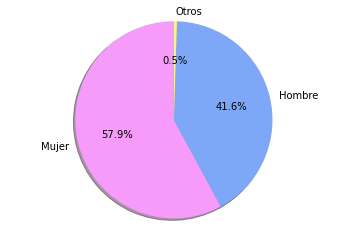

In [11]:
## Pie chart based on sex
piechart_labels = ['Mujer', 'Hombre', 'Otros']
values = df['sexo'].value_counts().tolist()
fig1, ax1 = plt.subplots()
#plt.title('Vacunados por Sexo')
ax1.pie(values, labels=piechart_labels, autopct='%1.1f%%', shadow=True, startangle=90, colors=['#f79bfa', '#7ea7f7', '#f5f29a'])
ax1.axis('equal')
plt.show()

In [5]:
## Vacunas por fabricante
from altair import *

header = Header(formatType="string", labelAngle=0, labelAlign=Align("left"), labelFontSize=15, titleFontSize=20)

temp_df = df['vacuna'].value_counts().rename_axis('Vacuna').reset_index(name='Aplicaciones')
alt.Chart(temp_df).mark_bar(size=60).encode(
    x=X('Aplicaciones:Q',axis=Axis(titleFontSize=20, labelFontSize=15, labelFontWeight='normal')),
    y=Y('Vacuna:O', sort='-x', axis=Axis(title='', labelFontSize=15, labelOverlap=False)),
    opacity=alt.value(0.8),
    color=alt.value('#7aedfa')
).properties(height=500, width=1200)


alt.Chart(...)

In [16]:
## Mapa de las provincias
import geopandas as gpd
from vega_datasets import data
from shapely import wkt

## Limpiamos los nombres de las provincias
df.loc[df.jurisdiccion_aplicacion == "CÃ³rdoba", "jurisdiccion_aplicacion"] = "Córdoba"
df.loc[df.jurisdiccion_aplicacion == "Entre RÃ­os", "jurisdiccion_aplicacion"] = "Entre Ríos"
df.loc[df.jurisdiccion_aplicacion == "TucumÃ¡n", "jurisdiccion_aplicacion"] = "Tucumán"
df.loc[df.jurisdiccion_aplicacion == "RÃ­o Negro", "jurisdiccion_aplicacion"] = "Rí­o Negro"
df.loc[df.jurisdiccion_aplicacion == "NeuquÃ©n", "jurisdiccion_aplicacion"] = "Neuquén"
provincias_df = df['jurisdiccion_aplicacion'].value_counts().rename_axis('Provincia').reset_index(name='Aplicaciones')

## Se tiene que leer como geodataframe
geoprovince_df = pd.read_csv('datos\provincia.csv')
geoprovince_df.loc[geoprovince_df.fna == "Ciudad Autónoma de Buenos Aires", "nam"] = "CABA"
geoprovince_df = geoprovince_df.rename(columns={'nam': 'Provincia', 'geom': 'geometry'})

merged_df = pd.merge(geoprovince_df, provincias_df, on=['Provincia'])
merged_df = merged_df[['Provincia', 'geometry', 'Aplicaciones']]

merged_df['geometry'] = merged_df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, crs='epsg:4326')

choro_json = json.loads(gdf.to_json())
choro_data = alt.Data(values=choro_json['features'])


,Provincia,geometry,Aplicaciones
0,CABA,MULTIPOLYGON(((-58.3418873969999 -34.631096715...,163
1,Neuquén,MULTIPOLYGON(((-68.2499999999999 -37.574784639...,2
2,San Luis,"MULTIPOLYGON(((-66.661788297 -31.920536028,-66...",6
3,Santa Fe,MULTIPOLYGON(((-58.8808218779999 -28.066824880...,23
4,La Rioja,"MULTIPOLYGON(((-65.422985216 -30.119602485,-65...",32


In [ ]:
choro = alt.Chart(choro_data,
    title='Aplicaciones de vacunas por provincia'
).mark_geoshape(
    stroke='black',
    strokeWidth=1
).encode(
    alt.Color("properties['Aplicaciones']",
    type='quantitative',
    scale=alt.Scale(scheme='bluegreen', type='log'),
    title = 'Aplicaciones de vacuna'
    )
)

tooltip = alt.Chart(choro_data
).mark_geoshape(
    fill='transparent',
    stroke='black',
    strokeWidth=0.1
).encode(
    tooltip=[alt.Tooltip('properties.Provincia:O', title="Provincia"), alt.Tooltip("properties['Aplicaciones']:Q", title="Aplicaciones de vacunas")],
)

